In [1]:
import sys
sys.path.insert(0, '/Users/william/Documents/CMU/Research/RiskSensitiveLearning/Supervised Learning/objectives')
import cvar, human_aligned_risk, entropic_risk, trimmed_risk, mean_variance

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
import scipy

In [2]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

learning_rate = 0.01

input_size = 1
h1 = 10
h2 = 5
epochs = 200

class RegressionMLP(nn.Module):
    def __init__(self, input_size, h1, h2):
        super(RegressionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

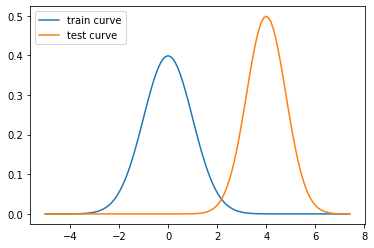

In [3]:
mean_train = 0
std_train = 1
mean_test = 4
std_test = 0.8

X_train = np.arange(-5, 7.5, 0.1)
y_train = scipy.stats.norm(mean_train, std_train).pdf(X_train)

X_test = np.arange(-5, 7.5, 0.1)
y_test = scipy.stats.norm(mean_test, std_test).pdf(X_test)

plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

In [4]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
inputs = torch.tensor(X_train, dtype=torch.float)
labels = torch.tensor(y_train, dtype=torch.float)

## Exepected Loss


0.09433013200759888
Final training loss:  0.0006489594816230237


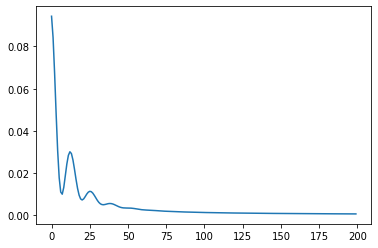

In [5]:
criterion = nn.MSELoss(reduction='mean')

model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    
    loss = criterion(output, labels.type(torch.float32))
    train_losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", train_losses[-1])
plt.plot(train_losses, label='train loss')

model.eval()
test_losses = []

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))
        test_losses.append(criterion(output, torch.tensor(y, dtype=torch.float32)).item())
        
output_curve = []
with torch.no_grad():
    for X in X_test:
        output_curve.append(model(torch.tensor(X, dtype=torch.float32)).item())

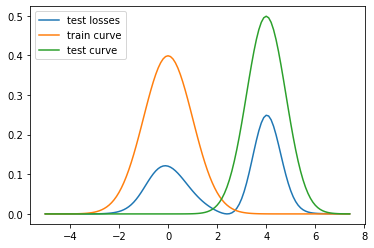

In [6]:
plt.plot(X_test.flatten(), test_losses, label='test losses')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

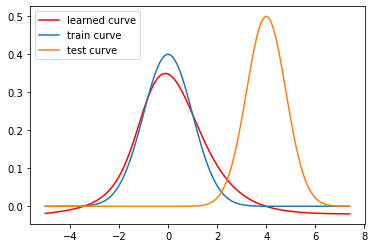

In [7]:
plt.plot(X_test, output_curve, color='r', label='learned curve')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

## Entropic Risk

0.0975821390748024
Final training loss:  0.0014994603116065264


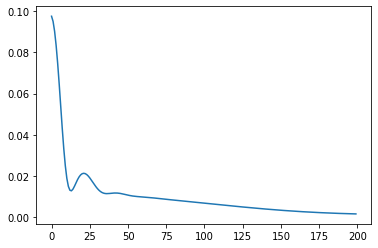

In [115]:
criterion = entropic_risk.EntropicRisk(t=-10, criterion=nn.MSELoss(reduction='none'))
model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    
    loss = criterion(output, labels.type(torch.float32))
    train_losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", train_losses[-1])
plt.plot(train_losses, label='train loss')

model.eval()
test_losses = []

criterion = nn.MSELoss(reduction='mean')

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))
        test_losses.append(criterion(output, torch.tensor(y, dtype=torch.float32)).item())
        
output_curve = []
with torch.no_grad():
    for X in X_test:
        output_curve.append(model(torch.tensor(X, dtype=torch.float32)).item())

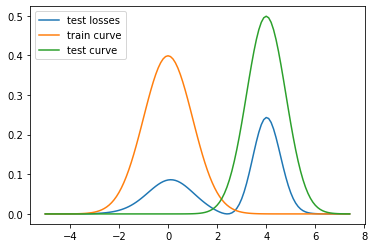

In [116]:
plt.plot(X_test.flatten(), test_losses, label='test losses')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

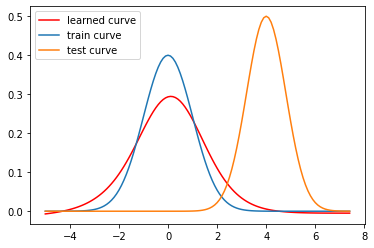

In [117]:
plt.plot(X_test, output_curve, color='r', label='learned curve')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

## CVaR

In [119]:
class CVaR(nn.Module):
    def __init__(self, a=0.05, inverted=False, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.inverted = inverted
        self.criterion = criterion
        self.reduction = reduction
    
    def _value_at_risk(self, loss):
        sorted_loss, sorted_indices = torch.sort(loss, dim=0, descending=False, stable=True)
        empirical_cdf = torch.argsort(sorted_indices, dim=0) / float(len(loss))
        sorted_cdf, _ = torch.sort(empirical_cdf, dim=0, descending=False, stable=True)
        value_at_risk_idx = np.searchsorted(sorted_cdf.flatten(), 1 - self.a, side='left').item()
        sorted_loss = sorted_loss.flatten().detach().numpy()
        return sorted_loss[value_at_risk_idx]
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        
        multiplier = 1
        if self.inverted:
            loss *= -1
            multiplier = -1
            
        values_at_risk = (loss >= self._value_at_risk(loss)).nonzero().squeeze()[:, 0].flatten()
        
        if self.reduction == 'mean':
            return multiplier * torch.mean(torch.index_select(loss, 0, values_at_risk))
        elif self.reduction == 'sum':
            return multiplier * Ztorch.sum(torch.index_select(loss, 0, values_at_risk))
        return values_at_risk

0.6389977335929871
Final training loss:  0.0006662349333055317


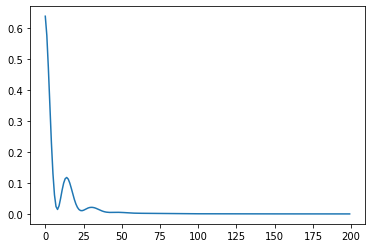

In [132]:
criterion = CVaR(a=0.95, inverted=False, criterion=nn.MSELoss(reduction='none'))
model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    
    loss = criterion(output, labels.type(torch.float32))
    train_losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", train_losses[-1])
plt.plot(train_losses, label='train loss')

model.eval()
test_losses = []

criterion = nn.MSELoss(reduction='mean')

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))
        test_losses.append(criterion(output, torch.tensor(y, dtype=torch.float32)).item())
        
output_curve = []
with torch.no_grad():
    for X in X_test:
        output_curve.append(model(torch.tensor(X, dtype=torch.float32)).item())

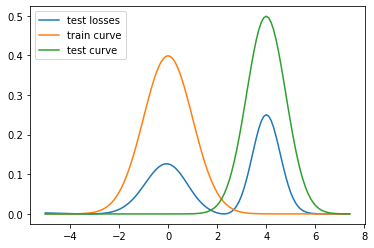

In [133]:
plt.plot(X_test.flatten(), test_losses, label='test losses')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

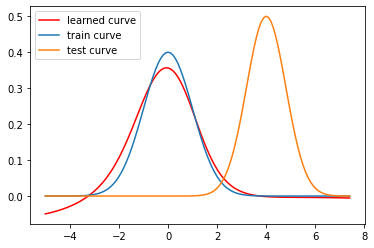

In [134]:
plt.plot(X_test, output_curve, color='r', label='learned curve')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

## Trimmed Risk

In [138]:
class TrimmedRisk(nn.Module):
    def __init__(self, a=0.05, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        assert a >= 0 and a <= 0.5, 'a must be in [0, 0.5]'
        self.a = a
        self.criterion = criterion
        self.reduction = reduction
    
    def _get_untrimmed_losses(self, loss):
        sorted_indices = torch.argsort(loss, dim=0, descending=False)
        empirical_cdf = torch.argsort(sorted_indices, dim=0) / float(len(loss))
        return ((empirical_cdf >= self.a) & (empirical_cdf <= 1 - self.a)).nonzero().squeeze()
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        untrimmed_losses = self._get_untrimmed_losses(loss)[:, 0].flatten()
        
        if self.reduction == 'mean':
            return torch.mean(torch.index_select(loss, 0, untrimmed_losses))
        elif self.reduction == 'sum':
            return torch.sum(torch.index_select(loss, 0, untrimmed_losses))
        return torch.index_select(loss, 0, untrimmed_losses)

0.21173903346061707
Final training loss:  0.0007271766662597656


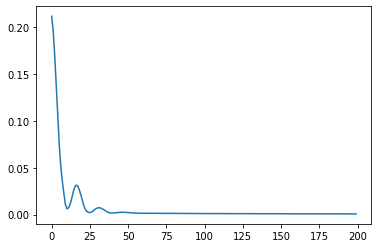

In [143]:
criterion = TrimmedRisk(a=0.25, criterion=nn.MSELoss(reduction='none'))
model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    
    loss = criterion(output, labels.type(torch.float32))
    train_losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", train_losses[-1])
plt.plot(train_losses, label='train loss')

model.eval()
test_losses = []

criterion = nn.MSELoss(reduction='mean')

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))
        test_losses.append(criterion(output, torch.tensor(y, dtype=torch.float32)).item())
        
output_curve = []
with torch.no_grad():
    for X in X_test:
        output_curve.append(model(torch.tensor(X, dtype=torch.float32)).item())

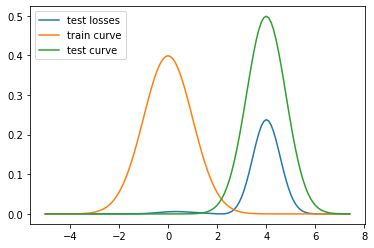

In [144]:
plt.plot(X_test.flatten(), test_losses, label='test losses')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()

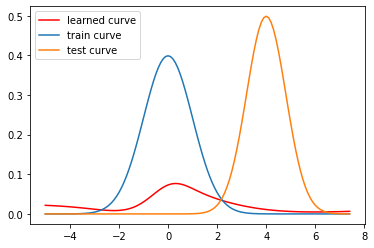

In [145]:
plt.plot(X_test, output_curve, color='r', label='learned curve')
plt.plot(X_train, y_train, label='train curve')
plt.plot(X_test, y_test, label='test curve')
plt.legend()